# Imports

In [64]:
from scripts.extract import convert_xml_to_dataframe
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Input, Dense, Normalization
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [65]:
RANDOM_STATE = 1

# Load data

In [66]:
# df = convert_xml_to_dataframe()
df = pd.read_csv('../data/patients.csv')

X = df[[
    # 'PATIENT_ID',
    # 'SEX',
    # 'BIRTH_DATE',
    # 'VISIT_DATE',
    # 'TREATING_PROVIDER',
    'BLEEDING_ON_PROBING',
    'NR_OF_POCKET',
    'NR_OF_FURCATION',
    'NR_OF_MOBILITY',
    'TOTAL_LOSS_OF_ATTACHMENT_LEVEL'
]]

y = df[[
    'HAS_PARODONTITIS'
]]
# df.head()

# Split train and test data

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=RANDOM_STATE)

In [68]:
y_train_without_parodontitis = y_train[y_train["HAS_PARODONTITIS"] == 0]
y_test_without_parodontitis = y_test[y_test["HAS_PARODONTITIS"] == 0]

print(f'y_train: {(100/len(y_train)) * len(y_train_without_parodontitis)}% without parodontitis')
print(f'y_test: {(100/len(y_test)) * len(y_test_without_parodontitis)}% without parodontitis')

y_train: 66.26666666666667% without parodontitis
y_test: 66.27624625053564% without parodontitis


# Normalization

In [69]:
normalizer = Normalization(axis=-1)
normalizer.adapt(np.array(X_train))

# Training

In [70]:
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    normalizer,
    Dense(10, activation='softmax'),
    # Dense(, activation='softmax'),
    Dense(2, activation='softmax')
])

model.compile(Adam(learning_rate=0.01), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_4 (Normalizat  (None, 5)                11        
 ion)                                                            
                                                                 
 dense_8 (Dense)             (None, 10)                60        
                                                                 
 dense_9 (Dense)             (None, 2)                 22        
                                                                 
Total params: 93
Trainable params: 82
Non-trainable params: 11
_________________________________________________________________


In [71]:
history = model.fit(X_train, y_train, epochs=10, validation_split=0.1)

Epoch 1/10
85/85 [==============================] - 1s 4ms/step - loss: 0.3351 - accuracy: 0.9385 - val_loss: 0.1343 - val_accuracy: 0.9933
Epoch 2/10
85/85 [==============================] - 0s 2ms/step - loss: 0.0865 - accuracy: 0.9922 - val_loss: 0.0434 - val_accuracy: 0.9933
Epoch 3/10
85/85 [==============================] - 0s 2ms/step - loss: 0.0348 - accuracy: 0.9963 - val_loss: 0.0219 - val_accuracy: 0.9967
Epoch 4/10
85/85 [==============================] - 0s 2ms/step - loss: 0.0204 - accuracy: 0.9974 - val_loss: 0.0135 - val_accuracy: 1.0000
Epoch 5/10
85/85 [==============================] - 0s 2ms/step - loss: 0.0141 - accuracy: 0.9978 - val_loss: 0.0091 - val_accuracy: 1.0000
Epoch 6/10
85/85 [==============================] - 0s 2ms/step - loss: 0.0104 - accuracy: 0.9985 - val_loss: 0.0067 - val_accuracy: 1.0000
Epoch 7/10
85/85 [==============================] - 0s 2ms/step - loss: 0.0080 - accuracy: 0.9985 - val_loss: 0.0053 - val_accuracy: 1.0000
Epoch 8/10
85/85 [==

# Performance evaluation

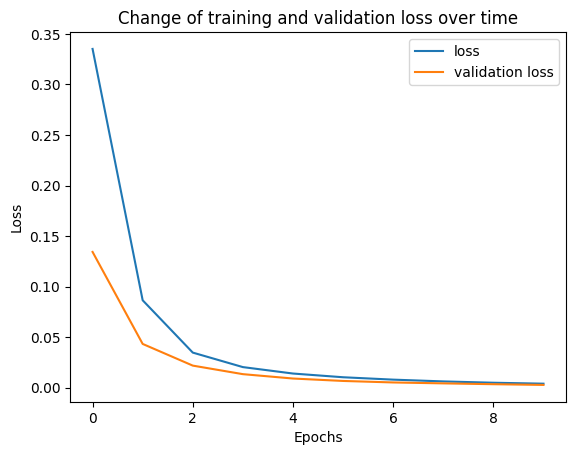

In [72]:
plt.plot(history.history["loss"], label = "loss")
plt.plot(history.history["val_loss"], label = "validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Change of training and validation loss over time")
plt.show()

# Saving the model

In [73]:
# now = datetime.now()
# formatted_date = now.strftime('%Y%m%d%H%M%S')
# model.save(f'../models/model-{formatted_date}.h5')
# print(f'Model saved: model-{formatted_date}.h5')

## Validation using the test set

In [74]:
result = model.predict(X_test)
result = pd.DataFrame(result)

result['PREDICTION'] = result.apply(lambda x: 0 if x.loc[0] > x.loc[1] else 1, axis=1)

y_test = y_test.reset_index()
y_test['PREDICTION'] = result['PREDICTION']

validation_result = y_test[['PREDICTION', 'HAS_PARODONTITIS']]

219/219 [==============================] - 0s 1ms/step


In [75]:
wrong_prediction = validation_result[validation_result["HAS_PARODONTITIS"] != validation_result['PREDICTION']]
print(f"Predicted wrong: {len(wrong_prediction)}/{len(validation_result)}")

Predicted wrong: 5/7001
